In [1]:
# importing tensorflow and matplotlib 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

batch_size = 32
image_size = 256
channels = 3
no_of_classes = 3


dataset = tf.keras.utils.image_dataset_from_directory(
        'DataSet', 
        color_mode='rgb', 
        batch_size=batch_size, 
        image_size=(image_size, image_size), 
        shuffle=True 
)

Found 2152 files belonging to 3 classes.


In [3]:
classes = dataset.class_names
classes

['Early blight Potato', 'Late blight Potato', 'healthy Potato']

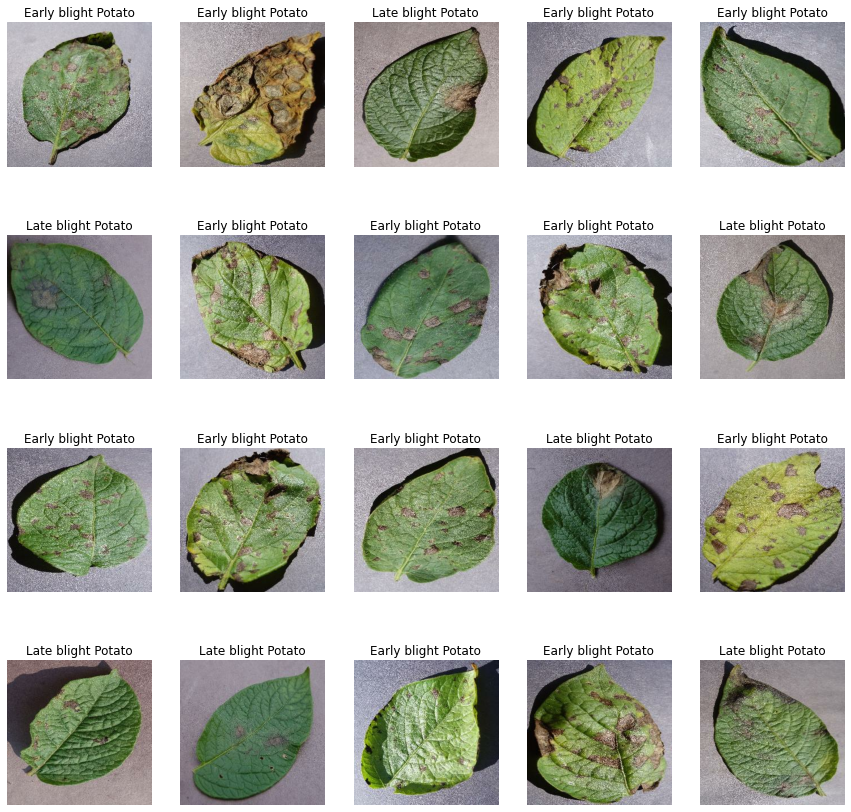

In [4]:
plt.figure(figsize= (15, 15))

for image_batch, label_batch in dataset.take(1):
    for i in range (20):
        ax = plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('int'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [5]:
# Number of batches of Dataset
# 1 batch having 32 images

size_of_ds = len(dataset)
size_of_ds

68

In [6]:
def get_ds_split(ds, training_ds_per=0.7, val_ds_per=0.15, test_ds_per=0.15, shuffle=True, shuffle_size=1000):
    assert (training_ds_per + test_ds_per + val_ds_per) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=2)
    
    train_size = int(training_ds_per * ds_size)
    val_size = int(val_ds_per * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
training_ds, validation_ds, testing_ds = get_ds_split(dataset)

In [8]:
len(training_ds)

47

In [9]:
len(validation_ds)

10

In [10]:
len(testing_ds)

11

In [11]:
train_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = testing_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1/255),
])

In [13]:
data_aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
input_shape = ( batch_size, image_size, image_size, channels )


model = models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(no_of_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
epochs = 50
history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
)

Epoch 1/50
47/47 [==============================] - 121s 2s/step - loss: 0.8803 - accuracy: 0.5041 - val_loss: 0.8266 - val_accuracy: 0.5156
Epoch 2/50
47/47 [==============================] - 114s 2s/step - loss: 0.6713 - accuracy: 0.6750 - val_loss: 0.4686 - val_accuracy: 0.7937
Epoch 3/50
47/47 [==============================] - 114s 2s/step - loss: 0.4106 - accuracy: 0.8209 - val_loss: 0.4233 - val_accuracy: 0.8281
Epoch 4/50
47/47 [==============================] - 127s 3s/step - loss: 0.3286 - accuracy: 0.8628 - val_loss: 0.2781 - val_accuracy: 0.8844
Epoch 5/50
47/47 [==============================] - 128s 3s/step - loss: 0.2952 - accuracy: 0.8865 - val_loss: 0.3519 - val_accuracy: 0.8656
Epoch 6/50
47/47 [==============================] - 125s 3s/step - loss: 0.2608 - accuracy: 0.8939 - val_loss: 0.3186 - val_accuracy: 0.8781
Epoch 7/50
47/47 [==============================] - 136s 3s/step - loss: 0.2106 - accuracy: 0.9196 - val_loss: 0.2883 - val_accuracy: 0.8906
Epoch 8/50
47

In [63]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 7s 473ms/step - loss: 0.0141 - accuracy: 0.9943


In [64]:
scores

[0.014109241776168346, 0.9943181872367859]

In [65]:
history.history['accuracy']

[0.49189189076423645,
 0.6222972869873047,
 0.7716216444969177,
 0.7972972989082336,
 0.7905405163764954,
 0.8986486196517944,
 0.8891891837120056,
 0.9155405163764954,
 0.908108115196228,
 0.9229729771614075,
 0.9128378629684448,
 0.9087837934494019,
 0.9236486554145813,
 0.9283784031867981,
 0.9594594836235046,
 0.9675675630569458,
 0.9750000238418579,
 0.9439189434051514,
 0.9520270228385925,
 0.9824324250221252,
 0.9702702760696411,
 0.9790540337562561,
 0.9817567467689514,
 0.9817567467689514,
 0.9858108162879944,
 0.9790540337562561,
 0.9885135293006897,
 0.9790540337562561,
 0.9898648858070374,
 0.9783783555030823,
 0.991216242313385,
 0.987162172794342,
 0.9925675392150879,
 0.9918919205665588,
 0.991216242313385,
 0.9925675392150879,
 0.9932432174682617,
 0.9925675392150879,
 0.991216242313385,
 0.9905405640602112,
 0.9918919205665588,
 0.9966216087341309,
 0.9783783555030823,
 0.9939188957214355,
 0.9932432174682617,
 0.9952702522277832,
 0.9844594597816467,
 0.99189192056655

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

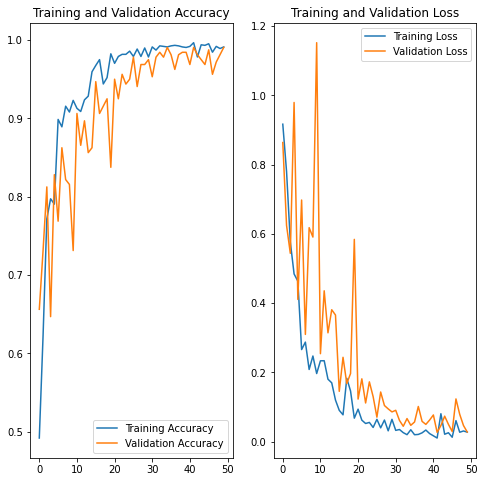

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Early blight Potato
predicted label: Early blight Potato


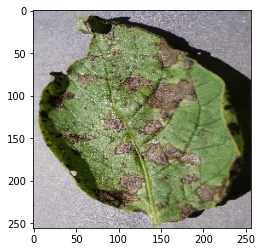

In [68]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes [np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

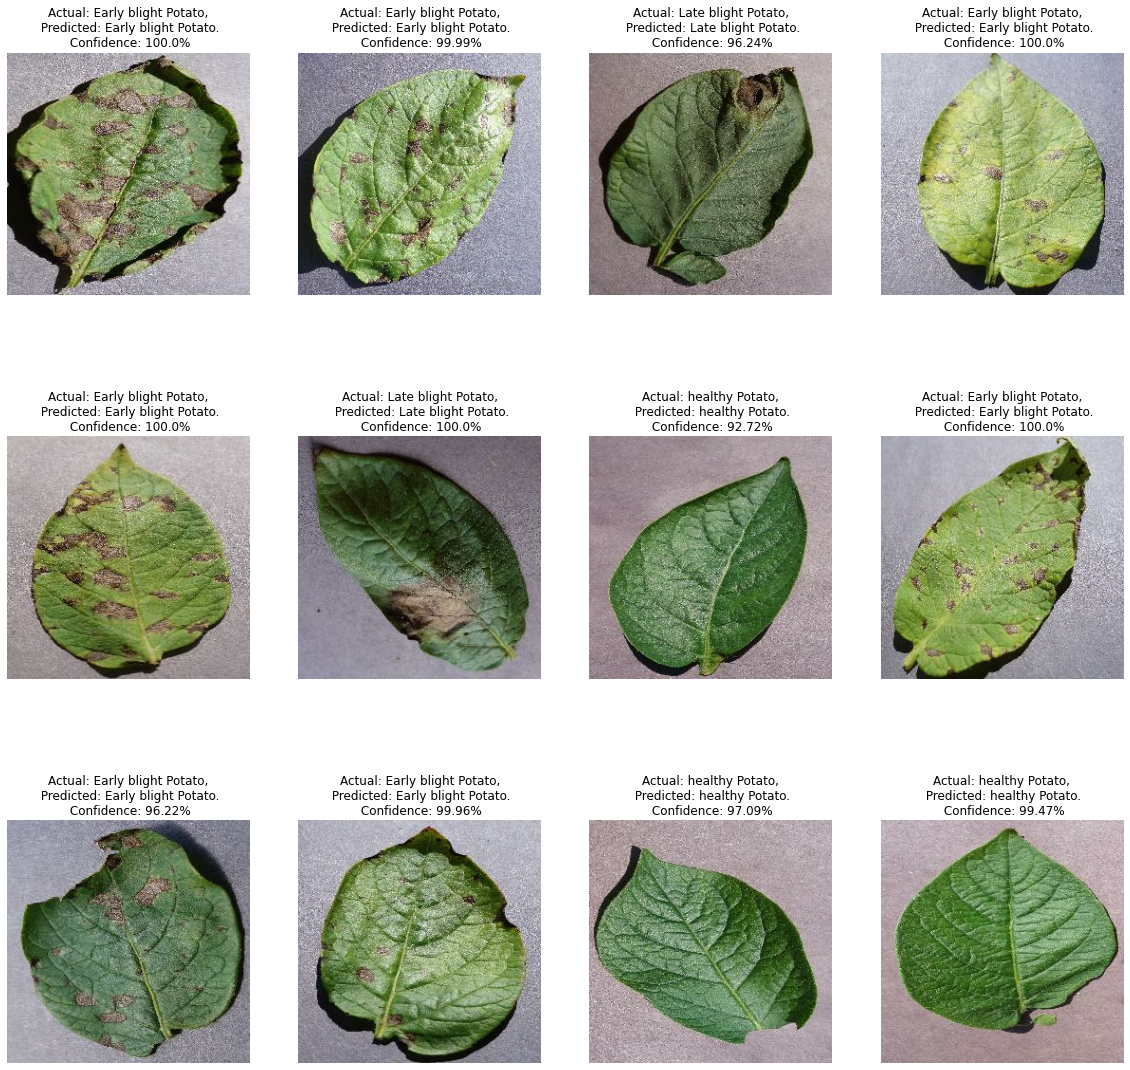

In [70]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("int"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [71]:
model.save("../NewModel.h5")

INFO:tensorflow:Assets written to: ../model_3\assets
